In [1]:

from __future__ import print_function

import sys

# sys.path.extend(['/home/jogi/git/repository/dcnn_acdc'])
sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm


from datetime import datetime
from pytz import timezone
import itertools
import copy

import SimpleITK as sitk
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from config.config import config
from common.dslices.config import config as sd_config
from utils.experiment import Experiment, ExperimentHandler
from utils.test_handler import ACDC2017TestHandler, test_ensemble


from utils.dslices.exper_handler import ExperHandlerEnsemble, ExperimentHandler as ExperimentHandlerSD
from utils.dslices.exper_handler import get_experiment_handlers
from utils.dslices.experiment import Experiment as ExperimentSD
from common.dslices.parsing import run_dict, create_def_argparser

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"
LOG_DIR = os.path.join(ROOT_DIR, "logs")
CYCLE_OFFSET = 100000
# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
np.random.seed(SEED)

# IMPORTANT - THE FOLD WE'RE USING FOR TESTING. NOTE: Training and testing fold should be the same
# we raise an error in the test_ensemble method if this is not the case!
TEST_FOLD = 1

seg_exper_ensemble = ExperHandlerEnsemble(sd_config.exper_dict_brier)

exp_mc01_brier = {3: "20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02",
                  2: "20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02",
                  1: "20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02",
                  0: "20180418_15_02_05_dcnn_mcv1_150000E_lr2e02"}
exp_mc01_brier_path = os.path.join(LOG_DIR, exp_mc01_brier[TEST_FOLD])


exp_mc01_softdice = {3: "20180630_10_26_32_dcnn_mc_f3p01_150KE_lr2e02",
                    2: "20180630_10_27_07_dcnn_mc_f2p01_150KE_lr2e02",
                    1: "20180629_11_28_29_dcnn_mc_f1p01_150KE_lr2e02",
                    0: "20180629_10_33_08_dcnn_mc_f0p01_150KE_lr2e02"}
exp_mc01_softdice_path = os.path.join(LOG_DIR, exp_mc01_softdice[TEST_FOLD])

exp_mc01_crossent = {3: "20180703_18_15_22_dcnn_mc_f3p01_entrpy_150KE_lr2e02",
                     2: "20180703_18_11_10_dcnn_mc_f2p01_entrpy_150KE_lr2e02",
                     1: "20180703_18_13_51_dcnn_mc_f1p01_entrpy_150KE_lr2e02",
                     0: "20180703_18_09_33_dcnn_mc_f0p01_entrpy_150KE_lr2e02"}
exp_mc01_crossent_path = os.path.join(LOG_DIR, exp_mc01_crossent[TEST_FOLD])

exper_hdl_mc01_brier = ExperimentHandler()
exper_hdl_mc01_brier.load_experiment(exp_mc01_brier_path, use_logfile=False)
exper_hdl_mc01_brier.set_root_dir(ROOT_DIR)
exper_hdl_mc01_brier.set_model_name("MC-dropout brier fold-{} (p={})".format(
                                exper_hdl_mc01_brier.exper.run_args.fold_ids[0],
                                exper_hdl_mc01_brier.exper.run_args.drop_prob))
print("Model name: {}".format(exper_hdl_mc01_brier.model_name))
print("-------------------------------------------------------------------------")

exper_hdl_mc01_softdice = ExperimentHandler()
exper_hdl_mc01_softdice.load_experiment(exp_mc01_softdice_path, use_logfile=False)
exper_hdl_mc01_softdice.set_root_dir(ROOT_DIR)
exper_hdl_mc01_softdice.set_model_name("MC-dropout soft-dice fold-{} (p={})".format(
                                exper_hdl_mc01_softdice.exper.run_args.fold_ids[0],
                                exper_hdl_mc01_softdice.exper.run_args.drop_prob))
# make sure we correct spelling for softdice to soft-dice, which we use in figures
exper_hdl_mc01_softdice.exper.run_args.loss_function = "soft-dice"
print("Model name: {}".format(exper_hdl_mc01_softdice.model_name))
print("-------------------------------------------------------------------------")

exper_hdl_mc01_crossent = ExperimentHandler()
exper_hdl_mc01_crossent.load_experiment(exp_mc01_crossent_path, use_logfile=False)
exper_hdl_mc01_crossent.set_root_dir(ROOT_DIR)
exper_hdl_mc01_crossent.set_model_name("MC-dropout cross-entropy fold-{} (p={})".format(
                                exper_hdl_mc01_crossent.exper.run_args.fold_ids[0],
                                exper_hdl_mc01_crossent.exper.run_args.drop_prob))
print("Model name: {}".format(exper_hdl_mc01_crossent.model_name))
print("-------------------------------------------------------------------------")

Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180418_15_02_05_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['0'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['1'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['2'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['3'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02/stats/exper_stats.dll
Model name: dcnn_mc p=0.10 fold=1 loss=brier


In [3]:
# exper_hdl.exper.run_args.fold_ids
exper_hdl = exper_hdl_mc01_brier
dataset = ACDC2017DataSet(exper_hdl.exper.config, search_mask=config.dflt_image_name + ".mhd",
                              fold_ids=[TEST_FOLD], preprocess=False,
                              debug=exper_hdl.exper.run_args.quick_run, do_augment=False,
                              incomplete_only=False)

  0%|          | 0/75 [00:00<?, ?it/s]

INFO - Using folds [1] - busy loading images/references...this may take a while!
INFO - >>> Search for /home/jorg/repository/dcnn_acdc/data/Folds/fold1/train/images_iso/*patient*.mhd <<<


100%|██████████| 25/25 [00:02<00:00,  9.10it/s]

INFO - Using folds [1] - loaded 200 files: 75 studies in train set, 25 studies in validation set
INFO - Mean width/height/#slices per image 235/263/9
---------------------- Image incompleteness statistics -------------------------
ES: slices missing RV/MYO/LV 0/0/0 (0.00/0.00/0.00) / complete 0 wo-all 0
ED: slices missing RV/MYO/LV 0/0/0 (0.00/0.00/0.00) / complete 0 wo-all 0


In [4]:
from in_out.dataset_slice_detector import create_dataset

args = create_def_argparser(**run_dict)

exper_hdl = ExperimentHandlerSD()
seg_exper_ensemble = ExperHandlerEnsemble(args.exper_dict)
seg_exper_hdl = seg_exper_ensemble.seg_exper_handlers[TEST_FOLD]

exper_hdl.set_exper(ExperimentSD(config, seg_exper=seg_exper_hdl.exper, run_args=args), use_logfile=True)


detect_dataset = create_dataset(exper_hdl, seg_exper_ensemble, type_of_map="e_map", degenerate_type="mean", 
                                pos_label=1, acdc_dataset=dataset)


Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180418_15_02_05_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['0'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['1'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['2'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['3'] loss=brier


  0%|          | 0/100 [00:00<?, ?it/s]

INFO - Loading referral results for thresholds [0.001]


100%|██████████| 100/100 [00:41<00:00,  2.42it/s]

INFO - Patients with degenerate slices train/test 69.0 / 24.0
INFO - #Patients in train/test set 69/24


In [25]:
from utils.dslices.batch_handler import BatchHandler as BatchHandlerSD

new_batch = BatchHandlerSD(data_set=detect_dataset, is_train=False, cuda=False)

print(detect_dataset.test_patient_ids)

['patient011', 'patient012', 'patient014', 'patient015', 'patient031', 'patient032', 'patient033', 'patient034', 'patient035', 'patient051', 'patient052', 'patient053', 'patient054', 'patient055', 'patient071', 'patient072', 'patient073', 'patient074', 'patient075', 'patient091', 'patient092', 'patient093', 'patient094', 'patient095']


205 286 51 171
Current patient ID patient012
(20, 3, 205, 286)
[171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199]
[171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199]
[171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199]
[171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199]


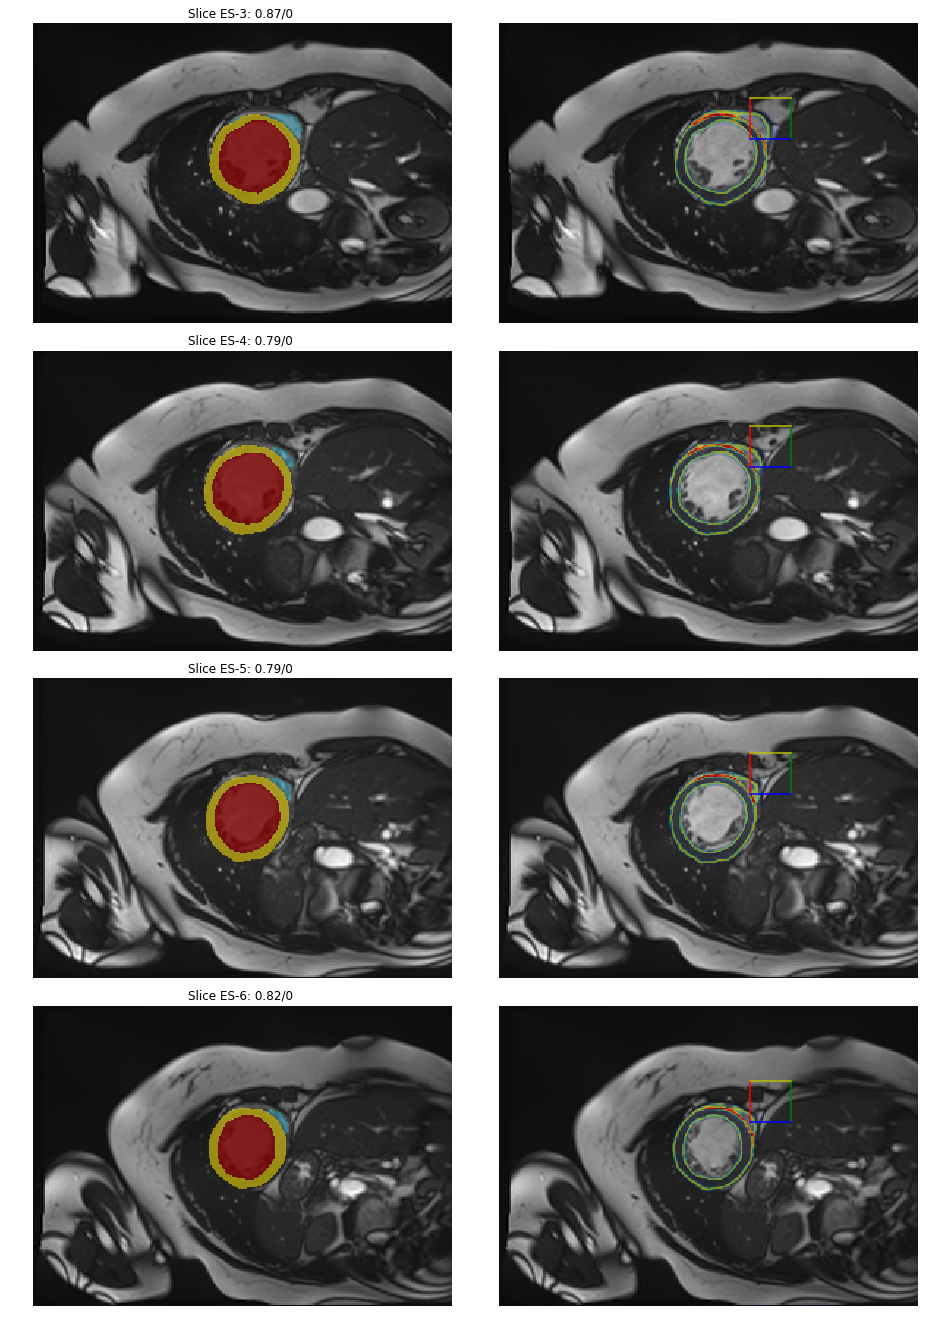

In [63]:



def transparent_cmap(cmap, N=255):
        "Copy colormap and set alpha values"
        mycmap = cmap
        mycmap._init()
        mycmap._lut[:, -1] = np.linspace(0, 0.8, N + 4)
        return mycmap

mycmap = transparent_cmap(plt.get_cmap('jet'))
batch_size = None
do_permute = False
plot_original = False
patient_id = "patient012"

x_input, y_lbl, y_extra_lbl = new_batch(batch_size=None, backward_freq=1, patient_id=patient_id,
                                        do_balance=False, do_permute=do_permute)



if batch_size is None or batch_size != x_input.shape[0]:
    batch_size = x_input.shape[0]

i_h, i_w = x_input.shape[2],  x_input.shape[3]
offx = np.random.randint(0, i_w-w_size)
offx = int(0.25 * i_h)
offy = np.random.randint(0, i_h-w_size)
offy = int(0.6 * i_w)
w_size = 28
print(i_h, i_w, offx, offy)
win_x1 = np.arange(offx, offx+w_size + 1)
win_y1 = np.full(win_x1.shape, offy)
win_y3 = np.full(win_x1.shape, offy+w_size)

win_y2 = np.arange(offy, offy+w_size + 1)
win_x2 = np.full(win_y2.shape, offx)
win_x3 = np.full(win_y2.shape, offx+w_size)

x_input = x_input.numpy()
y_lbl = y_lbl.numpy()
print("Current patient ID {}".format(new_batch.current_patient_id))
print(x_input.shape)
if batch_size is None:
    batch_size = x_input.shape[0]
    print("WARNING - setting batch size to {}".format(batch_size))
rows = batch_size * 2
columns = 4
if plot_original:
    columns = 6
    
height = 3 * rows
width = 16
column = 0
fig = plt.figure(figsize=(width, height))
row = 0

# rotate stuff
# x_input = np.rot90(x_input, k=2, axes=(2,3))

for b in np.arange(2, 6):
    img_slice = x_input[b, 0]
    seg_mask = x_input[b, 1]
    u_map = x_input[b, 2]
    slice_id = int(y_extra_lbl[b, 1])
    phase = "ES" if int(y_extra_lbl[b, 0]) == 0 else "ED"
    dice_slice = y_extra_lbl[b, 2]
    if plot_original:
        ax1 = plt.subplot2grid((rows, columns), (row, 0), rowspan=2, colspan=2)
        ax1.imshow(img_slice, cmap=cm.gray)
        plt.axis("off")
        column += 2
    ax2 = plt.subplot2grid((rows, columns), (row, column), rowspan=2, colspan=2)
    ax2.imshow(img_slice, cmap=cm.gray)
    ax2.set_title("Slice {}-{}: {:.2f}/{} ".format(phase, slice_id, dice_slice, y_lbl[b]))
    ax2.imshow(seg_mask, cmap=cm.jet)
    plt.axis("off")
    ax3 = plt.subplot2grid((rows, columns), (row, column+2), rowspan=2, colspan=2)
    ax3.imshow(img_slice, cmap=cm.gray)
    ax3_plot = ax3.imshow(u_map, cmap=mycmap)
    plt.axis("off")
    ax3.plot(win_y1, win_x1, 'r')
    ax3.plot(win_y3, win_x1, 'g')

    ax3.plot(win_y2, win_x2,'y')
    ax3.plot(win_y2, win_x3, 'b')
    plt.axis("off")
    row += 2

    